In [26]:
%load_ext autoreload

%autoreload 2
import matplotlib.pyplot as plt
import pickle
import emcee
from astropy.coordinates import SkyCoord, match_coordinates_3d, match_coordinates_sky
import sys
import numpy as np
from astropy.table import Table, QTable, hstack, vstack
import iminuit
from iminuit import Minuit
import corner

#module from my personnal github
sys.path.append('../modules/')
import analysis_Mass_Richness_relation as analysis
import CL_WL_miscentering as mis
import CL_WL_DATAOPS_make_profile as prf
import CL_WL_two_halo_term as twoh
import CL_WL_mass_conversion as utils
import CL_WL_fit_cluster_mass as fit
import CL_Likelihood_for_Mass_richness_relation as mr
import CL_fiducial_mass_richness_relation as fiducial
sys.path.append('/pbs/throng/lsst/users/cpayerne/ClusterLikelihoods/modules/')
import utils as ut

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
def load(filename, **kwargs):
    with open(filename, 'rb') as fin:
        return pickle.load(fin, **kwargs)

# Load data

In [5]:
profile_true = load('/pbs/throng/lsst/users/cpayerne/CLMassDC2/data/individual_profile_SkySim5000_gal_redMaPPer_cluster_epsilon_shape_true_z.pkl')

In [6]:
Z_bin = analysis.Z_bin
Obs_bin = analysis.Obs_bin

# Fit WL mass

## Estimating shear profiles & covariances

In [7]:
profile_true_stack = prf.stacked_profile(profile = profile_true,
                    r_in = 'radius_av',
                    gt_in = 'gt_av', gx_in = 'gx_av',
                    r_out = 'radius',
                    gt_out = 'gt', gx_out = 'gx',
                    weight = 'norm_sum',
                    z_name = 'cluster_z', obs_name = 'richness',
                    Z_bin = Z_bin, Obs_bin = Obs_bin)
covariance_true_stack = prf.bootstrap_covariance(profile = profile_true,
                    r_in = 'radius_av',
                    gt_in = 'gt_av', gx_in = 'gx_av',
                    r_out = 'radius',
                    gt_out = 'gt', gx_out = 'gx',
                    weight = 'norm_sum',
                    n_boot = 100,
                    z_name = 'cluster_z', obs_name = 'richness',
                    Z_bin = Z_bin, Obs_bin = Obs_bin)

/pbs/home/c/cpayerne/.conda/envs/mydesc/lib/python3.7/site-packages/numpy/ma/core.py:2832: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  order=order, subok=True, ndmin=ndmin)


## Fit halo mass
### MCMC & Minuit

In [14]:
down = 1
up = 5.5
a = 0
b = 1
#mcmc
fix_c_2h_mcmc =  fit.fit_WL_cluster_mass(profile = profile_true_stack, covariance = covariance_true_stack, a = a, b = b, rmax = up, two_halo_term = False, fix_c = False, method = 'mcmc', is_covariance_diagonal=True)

fitting...


In [27]:
#minuit
fix_c_2h_minuit =  fit.fit_WL_cluster_mass(profile = profile_true_stack, covariance = covariance_true_stack, a = a, b = b, rmax = up, two_halo_term = True, fix_c = False,
                                           method = 'minuit', is_covariance_diagonal=True, halo_model = 'nfw')

fitting...


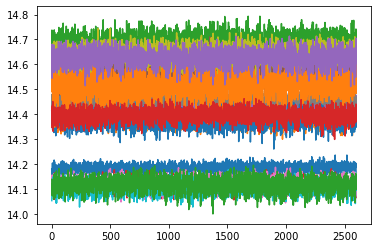

In [15]:
for p in fix_c_2h_mcmc:
    plt.plot(p['chain'][:,0][4000:])

4 3


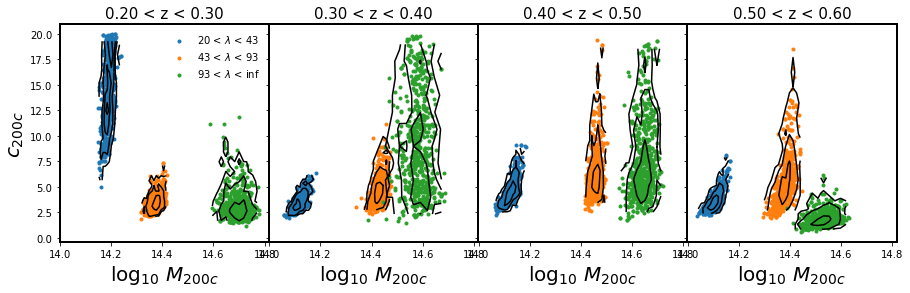

In [22]:
n_z_bin = len(Z_bin) - 1
n_m_bin = len(Obs_bin) - 0
print(n_z_bin, n_m_bin)
scale = 4
fig, axs = plt.subplots(1, n_z_bin, figsize = (15, 4),sharex = True, sharey = True)
plt.rcParams['axes.linewidth'] = 2
fig.subplots_adjust(wspace=0, hspace=0)
colors = ['#1f77b4', '#ff7f0e', '#2ca02c',]
for j, z_bin in enumerate(Z_bin):

    if j >= n_z_bin: continue
        
    for i, m_bin in enumerate(Obs_bin):

        if i >= n_m_bin: continue
        markersize = [2,2]
        name = ['center cosmoDC2', 'center RedMapper']
        profile_ = profile_true_stack
        mask_z = (profile_['z_mean'] > z_bin[0])*(profile_['z_mean'] < z_bin[1])
        mask_m = (profile_['obs_mean'] > m_bin[0])*(profile_['obs_mean'] < m_bin[1])
        index = np.arange(len(profile_['z_mean']))
        index_cut = index[mask_m * mask_z]
        p_mcmc = Table(fix_c_2h_mcmc)[index_cut][0]
        p_minuit = Table(fix_c_2h_minuit)[index_cut][0]
        H, x, y = np.histogram2d(p_mcmc['chain'][:,0][6000:], p_mcmc['chain'][:,1][6000:], bins=15)
        label = f'{Obs_bin[i][0]:.0f} < $\lambda$ < {Obs_bin[i][1]:.0f}'
        axs[j].scatter(p_mcmc['chain'][:,0][6000:], p_mcmc['chain'][:,1][6000:], s = 9, c = colors[i], label= label)
        ut.density_contour(p_mcmc['chain'][:,0][6000:], p_mcmc['chain'][:,1][6000:], 11, 11, c='k', ax=axs[j])
        #axs[j].scatter(p_minuit['logm200_w'], p_minuit['c_w'], s = 70, c='k', marker = '^')
        mean_mcmc = np.mean(p_mcmc['chain'][6000:], axis = 0)
        #axs[j].scatter(mean_mcmc[0], mean_mcmc[1], s = 70, c='m', marker = 's')
for i in range(n_z_bin):
    if i == 0:
        axs[i].set_ylabel(r'$c_{200c}$', fontsize = 20)
        axs[i].legend(frameon = False)
    title = f'{Z_bin[i][0]:.2f} < z < {Z_bin[i][1]:.2f}'
    axs[i].set_title(title, fontsize = 15)
    axs[i].set_xlabel(r'$\log_{10}\ M_{200c}$', fontsize = 20)
plt.savefig('/pbs/throng/lsst/users/cpayerne/ThesisAtCCin2p3/Images/mcmc_mass_WL.png', bbox_inches='tight', dpi=300)

In [60]:
mean = []
std = []
for p in fix_c_2h_mcmc:
    mean.append(np.mean(p['chain'][6000:], axis = 0)[0])
    std.append(np.std(p['chain'][6000:], axis = 0)[0])
fix_c_2h_mcmc['logm200_w'], fix_c_2h_mcmc['logm200_w_err'] = np.array(mean), np.array(std)

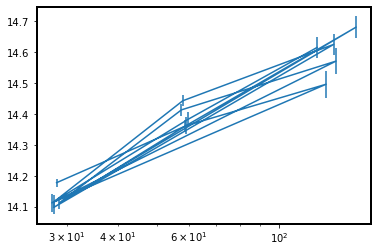

In [25]:
#plt.errorbar(fix_c_1h['obs_mean'], fix_c_1h['logm200_w'])
#plt.errorbar(fix_c_2h_mcmc['obs_mean'], fix_c_2h_mcmc['logm200_w'], fix_c_2h_mcmc['logm200_w_err'])
plt.errorbar(fix_c_2h_minuit['obs_mean'], fix_c_2h_minuit['logm200_w'], fix_c_2h_minuit['logm200_w_err'])
#plt.plot(free_c_1h['obs_mean'], free_c_1h['logm200_w'], '--')
#plt.plot(free_c_2h['obs_mean'], free_c_2h['logm200_w'], '--k')
plt.xscale('log')